In [ ]:
#importing libraries
import numpy as np 

%matplotlib inline 
#to use as command line calls #using inline graphs will come next to code

import matplotlib.pyplot as plt #for graphs
import os #for operating system dependent fucntionality
from keras import layers #for building layers of neural net
from keras.models import Model
from keras.models import load_model
from keras import callbacks #for training logs, saving to disk periodically
#from keras.callbacks import Tenserbord
import cv2 #OpenCV(Open Source computer vision lib), containg CV algos
import string


In [ ]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    414      0 --:--:-- --:--:-- --:--:--   414
100 8863k  100 8863k    0     0  9782k      0 --:--:-- --:--:-- --:--:-- 27.4M


In [ ]:
imgshape=(50,200,1)
n=1070
nchar=19
character= string.ascii_lowercase + "0123456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

36

In [ ]:


#preprocesss image
def preprocess():
  X = np.zeros((n,50,200,1)) #1070*50*200 array with all entries 0
  y = np.zeros((5,n,nchar)) #5*1070*36(5 letters in captcha) with all entries 0

  for i, pic in enumerate(os.listdir("/content/captcha_images_v2")):
  #i represents index no. of image in directory 
  #pic contains the file name of the particular image to be preprocessed at a time
    
    img = cv2.imread(os.path.join("/content/captcha_images_v2", pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale format
    pic_target = pic[:-4]#this drops the .png extension from file name and contains only the captcha for training
    
    if len(pic_target) < 6: #captcha is not more than 5 letters
      img = img / 255.0 #scales the image between 0 and 1
      img = np.reshape(img, (50, 200, 1)) #reshapes image to width 200 , height 50 ,channel 1 

      target=np.zeros((5,nchar)) #creates an array of size 5*36 with all entries 0

      for j, k in enumerate(pic_target):
      #j iterates from 0 to 4(5 letters in captcha)
      #k denotes the letter in captcha which is to be scanned
         index = character.find(k) #index stores the position of letter k of captcha in the character string
         target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

      X[i] = img #stores all the images
      y[:,i] = target #stores all the info about the letters in captcha of all images

  return X,y



In [ ]:
X,y=preprocess()

In [ ]:
#create model
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*200
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 7*25
    
    flat = layers.Flatten()(mp3) #convert the layer into 1-D

    outs = []
    for _ in range(5): #for 5 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='sigmoid')(drop)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [ ]:
#Create model
model=createmodel();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 100, 32)  4640        ['max_pooling2d[0][0]']      

In [ ]:
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [ ]:
#fit data to model 
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=60, validation_split=0.2)

Epoch 1/60
25/25 [==============================] - 10s 305ms/step - loss: 17.8597 - dense_1_loss: 3.5116 - dense_3_loss: 3.6189 - dense_5_loss: 3.6054 - dense_7_loss: 3.5658 - dense_9_loss: 3.5581 - dense_1_accuracy: 0.0644 - dense_3_accuracy: 0.0348 - dense_5_accuracy: 0.0374 - dense_7_accuracy: 0.0387 - dense_9_accuracy: 0.0606 - val_loss: 17.7419 - val_dense_1_loss: 3.5462 - val_dense_3_loss: 3.5552 - val_dense_5_loss: 3.5531 - val_dense_7_loss: 3.5388 - val_dense_9_loss: 3.5486 - val_dense_1_accuracy: 0.0876 - val_dense_3_accuracy: 0.0412 - val_dense_5_accuracy: 0.1031 - val_dense_7_accuracy: 0.0722 - val_dense_9_accuracy: 0.0722
Epoch 2/60
25/25 [==============================] - 7s 277ms/step - loss: 16.6458 - dense_1_loss: 3.2520 - dense_3_loss: 3.3934 - dense_5_loss: 3.4061 - dense_7_loss: 3.3038 - dense_9_loss: 3.2906 - dense_1_accuracy: 0.0863 - dense_3_accuracy: 0.0412 - dense_5_accuracy: 0.0361 - dense_7_accuracy: 0.0657 - dense_9_accuracy: 0.0863 - val_loss: 17.7220 - val

In [ ]:
#fit data to model 
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=60, validation_split=0.2)

Epoch 1/60
25/25 [==============================] - 9s 284ms/step - loss: 17.8838 - dense_1_loss: 3.5489 - dense_3_loss: 3.6454 - dense_5_loss: 3.4847 - dense_7_loss: 3.5892 - dense_9_loss: 3.6157 - dense_1_accuracy: 0.0567 - dense_3_accuracy: 0.0593 - dense_5_accuracy: 0.0606 - dense_7_accuracy: 0.0451 - dense_9_accuracy: 0.0644 - val_loss: 17.6228 - val_dense_1_loss: 3.5313 - val_dense_3_loss: 3.5470 - val_dense_5_loss: 3.5037 - val_dense_7_loss: 3.5012 - val_dense_9_loss: 3.5397 - val_dense_1_accuracy: 0.0876 - val_dense_3_accuracy: 0.0928 - val_dense_5_accuracy: 0.0928 - val_dense_7_accuracy: 0.0773 - val_dense_9_accuracy: 0.0515
Epoch 2/60
25/25 [==============================] - 6s 257ms/step - loss: 16.6004 - dense_1_loss: 3.2554 - dense_3_loss: 3.4404 - dense_5_loss: 3.1828 - dense_7_loss: 3.2684 - dense_9_loss: 3.4535 - dense_1_accuracy: 0.0928 - dense_3_accuracy: 0.0786 - dense_5_accuracy: 0.0876 - dense_7_accuracy: 0.0696 - dense_9_accuracy: 0.0992 - val_loss: 17.5631 - val_

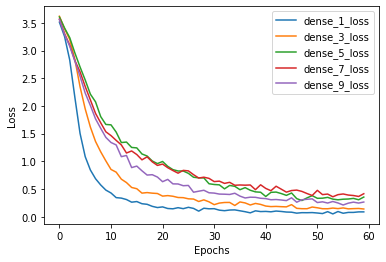

In [ ]:
#graph of loss vs epochs
for label in ["dense_1_loss"]:
  plt.plot(hist.history[label],label=label)
for label in ["dense_3_loss"]:
  plt.plot(hist.history[label],label=label)
for label in ["dense_5_loss"]:
  plt.plot(hist.history[label],label=label)
for label in ["dense_7_loss"]:
  plt.plot(hist.history[label],label=label)
for label in ["dense_9_loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [ ]:
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set= " + str(preds[0]))

31/31 [==============================] - 2s 79ms/step - loss: 0.5170 - dense_1_loss: 0.0354 - dense_3_loss: 0.0513 - dense_5_loss: 0.1552 - dense_7_loss: 0.1996 - dense_9_loss: 0.0755 - dense_1_accuracy: 0.9897 - dense_3_accuracy: 0.9897 - dense_5_accuracy: 0.9701 - dense_7_accuracy: 0.9577 - dense_9_accuracy: 0.9845
Loss on training set= 0.517044186592102


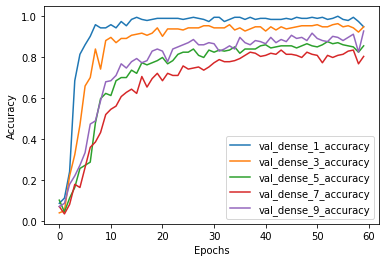

In [ ]:
for label in ["val_dense_1_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_3_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_5_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_7_accuracy"]:
  plt.plot(hist.history[label],label=label)
for label in ["val_dense_9_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None: #image foud at file path
        img = img / 255.0 #Scale image
    else:
        print("Not detected");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis])) #np.newaxis=1 
    #added this bcoz x_train 970*50*200*1
    #returns array of size 1*5*36 
    result = np.reshape(res, (5, 36)) #reshape the array
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    return capt

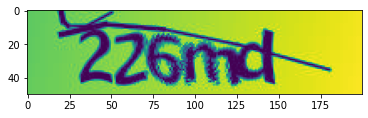

In [ ]:
#Check model on samples
img=cv2.imread('/content/captcha_images_v2/226md.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img)



In [ ]:
print("Predicted Captcha =",predict('/content/captcha_images_v2/226md.png'))

Predicted Captcha = 226md
